In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.mlab as mlab
import glob
from scipy import optimize
from scipy.special import erf
import os
import numpy.polynomial.polynomial as poly

In [2]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [3]:
def FIND_MAX(X,Y):
    TriggerTime = find_nearest(X,0)
    Trigger     = np.where(X==TriggerTime)[0][0]+5
    xx = moving_average(X,20)
    yy = moving_average(Y,20)
    
    xxx = xx[Trigger:]
    yyy = yy[Trigger:]
    
    maxy = max(yyy)
    
    hold      = find_nearest(yyy,maxy)
    peak     = np.where(yyy==hold)[0][0]

    xxx = xx[Trigger:Trigger+peak]
    yyy = yy[Trigger:Trigger+peak]
    
    hold      = find_nearest(yyy,maxy*0.1)
    edge     = np.where(yyy==hold)[0][0]
    return Trigger+peak, Trigger+edge

def FIND_MIN(X,Y):
    TriggerTime = find_nearest(X,0)
    Trigger     = np.where(X==TriggerTime)[0][0]+20
    xx = moving_average(X,20)
    yy = moving_average(Y,20)
    
    xxx = xx[Trigger:]
    yyy = yy[Trigger:]
    
    miny = min(yyy)
    
    hold      = find_nearest(yyy,miny)
    MINLOC     = np.where(yyy==hold)[0][0]
    
    TT = Trigger+MINLOC
    xxxx = xx[Trigger:TT]
    yyyy = yy[Trigger:TT]
    
    hold      = find_nearest(yyyy,miny*0.1)
    REDGE     = np.where(yyyy==hold)[0][0]
    return MINLOC+Trigger,miny,REDGE+Trigger

In [4]:
def funcG(t,t0,sig,a):
    tau = 121e-6
    A = (sig**2-2*(t-t0)*tau)/(2*tau**2)
    B = (-sig**2 +(t-t0)*tau)/(np.sqrt(2)*tau*sig)
    C = np.exp(A)
    D = (1 + erf(B))
    E = a*C*D
    return E

def funcA(t,t0,sig,a):
    tau = 123e-6
    A = (sig**2-2*(t-t0)*tau)/(2*tau**2)
    B = (-sig**2 +(t-t0)*tau)/(np.sqrt(2)*tau*sig)
    C = np.exp(A)
    D = (1 + erf(B))
    E = a*C*D
    return E

In [5]:
def FITTER_GOLD(x,y):
    avg=5
    YY = moving_average(y,avg)
    XX = moving_average(x,avg)
    pp,ee = FIND_MAX(XX,YY)
    I = ee + int((pp-ee)/2)
    MM = max(YY[I:])
    
    fitval = [XX[I],8e-6, MM]

    errfunc = lambda p, x, y: (funcG(x, *p) - y)**2
    optim, success = optimize.leastsq(errfunc, fitval, args=(XX,YY))
    return XX,YY,optim

In [6]:
def FITTER_ANOD(x,y):
    avg=5
    YY = moving_average(y,avg)
    XX = moving_average(x,avg)
    MM, MIN, RE = FIND_MIN(Data[0],Data[2])
    I2 = RE + int((MM-RE)/2)
    MM = min(YY[I2:])
    SIG = abs(x[MM]-x[RE])
    
    fitval = [XX[I2],8e-6, MM]
    #fitval = [XX[I],SIG, MM,150e-6]

    errfunc = lambda p, x, y: (funcA(x, *p) - y)**2
    optim, success = optimize.leastsq(errfunc, fitval, args=(XX,YY))
    return XX,YY,optim
    #return SIG

In [157]:
PATH = '/Users/austinmcdonald/Desktop/XeHe/Data/'
folders = glob.glob(PATH+"*/")
folders.sort()
folders

['/Users/austinmcdonald/Desktop/XeHe/Data/085/',
 '/Users/austinmcdonald/Desktop/XeHe/Data/090/',
 '/Users/austinmcdonald/Desktop/XeHe/Data/093/',
 '/Users/austinmcdonald/Desktop/XeHe/Data/095/',
 '/Users/austinmcdonald/Desktop/XeHe/Data/096/',
 '/Users/austinmcdonald/Desktop/XeHe/Data/097/',
 '/Users/austinmcdonald/Desktop/XeHe/Data/098/',
 '/Users/austinmcdonald/Desktop/XeHe/Data/099/',
 '/Users/austinmcdonald/Desktop/XeHe/Data/100/']

In [158]:
folders = [folders[0]]
folders

['/Users/austinmcdonald/Desktop/XeHe/Data/085/']

In [159]:
ff = os.listdir(folders[0])
ff.sort()
ff

['.DS_Store',
 'Xe-085_P-10_E-080.txt',
 'Xe-085_P-10_E-100.txt',
 'Xe-085_P-10_E-150.txt',
 'Xe-085_P-10_E-200.txt',
 'Xe-085_P-10_E-250.txt',
 'Xe-085_P-10_E-300.txt',
 'Xe-085_P-10_E-350.txt']

In [160]:
# arrival, sigma, max, RC
GOLDD = []
ANODE = []
REDU  = []
PRE = []
EFID = []
for F in range(0,len(folders)):
    files = os.listdir(folders[F])
    if '.DS_Store' in files: files.remove('.DS_Store')
    files.sort()
    for fi in files:
        Data = np.loadtxt(folders[F]+fi)
        #plt.plot(Data[0],Data[1],color='b')
        #plt.plot(Data[0],Data[2],color='g')
        
        XG,YG,OG = FITTER_GOLD(Data[0],Data[1])
        XA,YA,OA = FITTER_ANOD(Data[0],Data[2])
        #plt.plot(XG,YG,color='r')
        #plt.plot(XA,YA,color='r')
        #plt.show()

        EE =int(fi.split('.')[0].split('-')[-1])
        PP = int(fi.split('.')[0].split('-')[2].split('_')[0])
        #if EE ==350 or EE ==300 or EE ==250 or EE ==200 or EE ==150:
        #    PRE.append(PP)
        #    REDU.append(EE/PP)
        #    ANODE.append(OA)
        #    GOLDD.append(OG)
        #    EFID.append(EE)
 
        PRE.append(PP)
        REDU.append(EE/PP)
        ANODE.append(OA)
        GOLDD.append(OG)
        EFID.append(EE)
        '''if PP == 10:
            PRE.append(PP)
            REDU.append(EE/PP)
            ANODE.append(OA)
            GOLDD.append(OG)
            EFID.append(EE)'''
        #    ANODE.append(OA)
        #    GOLDD.append(OG)


//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [161]:
GOLDD = np.array(GOLDD)
ANODE = np.array(ANODE)
REDU  = np.array(REDU)
PRE   = np.array(PRE)
EFID   = np.array(EFID)

In [162]:
Dt = (ANODE[:,0] - GOLDD[:,0])*1e6

d = 138
Vd = d/Dt
x = 2*Dt/Vd**2
y = (ANODE[:,1]*1e6)**2-(GOLDD[:,1]*1e6)**2

Dl = y/x
Mu = Vd/EFID

In [163]:
difff =np.sqrt((273/296*2*PP)*Dl*1e8/Vd)
#difff =np.sqrt(Dl*1e8/Vd)

#Zp =12.123*(289.77/273.15)*(PRE/57.65) 
#Z0 = 0.22308122
#difff =np.sqrt((Z0/Zp*2*PRE)*Dl*1e8/Vd)

difff

//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':


array([ 10032.58296027,   7853.80483626,   6425.1212437 ,   7950.07197595,
         7603.17542726,   3998.04805446,             nan])

In [164]:
#Xe099d = difff
#Xe099r = REDU
#Xe090d = difff
#Xe090r = REDU
Xe085d = difff
Xe085r = REDU

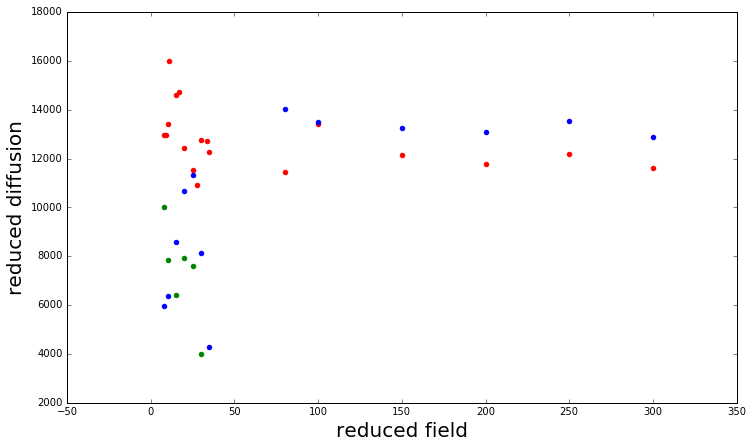

In [165]:
col=['b','g','r','k','m']
plt.figure(figsize=(12,7))
plt.scatter(Xe099r,Xe099d,color='r')
plt.scatter(Xe090r,Xe090d,color='b')
plt.scatter(Xe085r,Xe085d,color='g')
#plt.scatter(REDU,difff,color='m')

#plt.scatter(EFID,Dl)
#plt.errorbar(REDU[x],difff[x],yerr=100,color=col[1])

plt.xlabel('reduced field',fontsize=20)
plt.ylabel('reduced diffusion',fontsize=20)
#plt.scatter(REDU,difff)
#plt.scatter(dd[:,0],dd[:,1],color='y')
#plt.xlim(0,50)
#plt.ylim(0,2)

(0, 350)

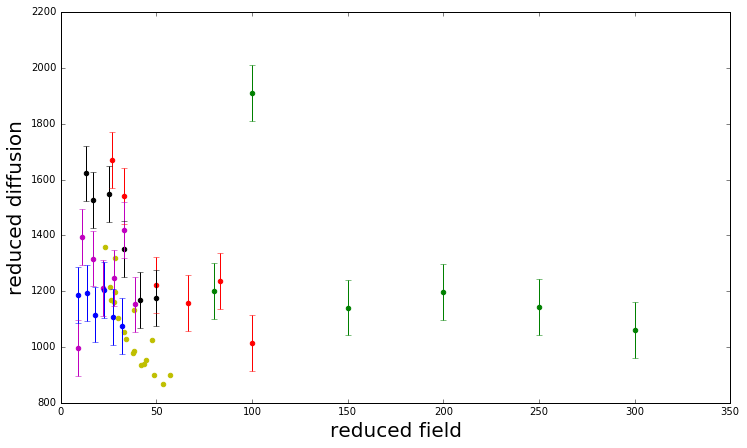

In [385]:
col=['b','g','r','k','m']
plt.figure(figsize=(12,7))
for x in range(0,len(PRE)):
    if PRE[x]==1:
        plt.scatter(REDU[x],difff[x],color=col[1])
        plt.errorbar(REDU[x],difff[x],yerr=100,color=col[1])
    if PRE[x]==3:
        plt.scatter(REDU[x],difff[x],color=col[2])
        plt.errorbar(REDU[x],difff[x],yerr=100,color=col[2])
    if PRE[x]==6:
        plt.scatter(REDU[x],difff[x],color=col[3])
        plt.errorbar(REDU[x],difff[x],yerr=100,color=col[3])
    if PRE[x]==9:
        plt.scatter(REDU[x],difff[x],color=col[4])
        plt.errorbar(REDU[x],difff[x],yerr=100,color=col[4])
    if PRE[x]==11:
        plt.scatter(REDU[x],difff[x],color=col[0])
        plt.errorbar(REDU[x],difff[x],yerr=100,color=col[0])
plt.xlabel('reduced field',fontsize=20)
plt.ylabel('reduced diffusion',fontsize=20)
#plt.scatter(REDU,difff)
plt.scatter(dd[:,0],dd[:,1],color='y')
plt.xlim(0,350)

(0, 350)

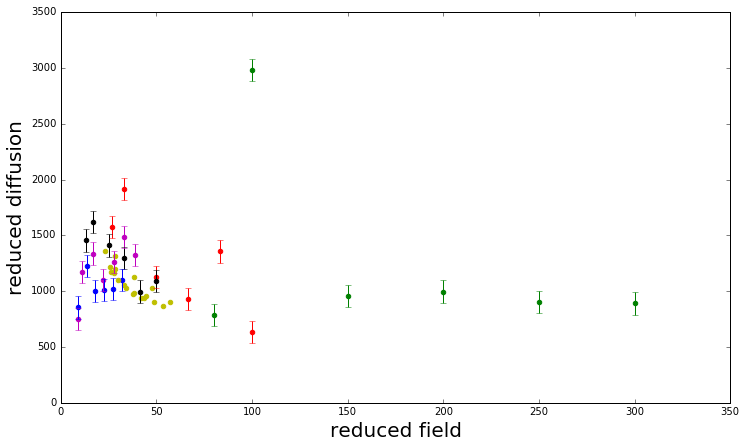

In [242]:
col=['b','g','r','k','m']
plt.figure(figsize=(12,7))
for x in range(0,len(PRE)):
    if PRE[x]==1:
        plt.scatter(REDU[x],difff[x],color=col[1])
        plt.errorbar(REDU[x],difff[x],yerr=100,color=col[1])
    if PRE[x]==3:
        plt.scatter(REDU[x],difff[x],color=col[2])
        plt.errorbar(REDU[x],difff[x],yerr=100,color=col[2])
    if PRE[x]==6:
        plt.scatter(REDU[x],difff[x],color=col[3])
        plt.errorbar(REDU[x],difff[x],yerr=100,color=col[3])
    if PRE[x]==9:
        plt.scatter(REDU[x],difff[x],color=col[4])
        plt.errorbar(REDU[x],difff[x],yerr=100,color=col[4])
    if PRE[x]==11:
        plt.scatter(REDU[x],difff[x],color=col[0])
        plt.errorbar(REDU[x],difff[x],yerr=100,color=col[0])
plt.xlabel('reduced field',fontsize=20)
plt.ylabel('reduced diffusion',fontsize=20)
#plt.scatter(REDU,difff)
plt.scatter(dd[:,0],dd[:,1],color='y')
plt.xlim(0,350)

(50, 370)

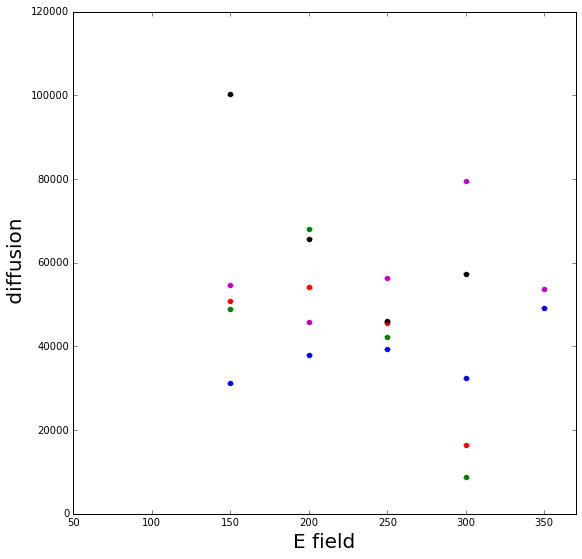

In [261]:
col=['b','g','r','k','m']
plt.figure(figsize=(9,9))
for x in range(0,len(PRE)):
    if PRE[x]==1:
        plt.scatter(EFID[x],Dl[x]*1e8,color=col[1])
        plt.errorbar(EFID[x],Dl[x]*1e8,yerr=100,color=col[1])
    if PRE[x]==3:
        plt.scatter(EFID[x],Dl[x]*1e8,color=col[2])
        plt.errorbar(EFID[x],Dl[x]*1e8,yerr=100,color=col[2])
    if PRE[x]==6:
        plt.scatter(EFID[x],Dl[x]*1e8,color=col[3])
        plt.errorbar(EFID[x],Dl[x]*1e8,yerr=100,color=col[3])
    if PRE[x]==9:
        plt.scatter(EFID[x],Dl[x]*1e8,color=col[4])
        plt.errorbar(EFID[x],Dl[x]*1e8,yerr=100,color=col[4])
    if PRE[x]==11:
        plt.scatter(EFID[x],Dl[x]*1e8,color=col[0])
        plt.errorbar(EFID[x],Dl[x]*1e8,yerr=100,color=col[0])
        
#plt.scatter(REDU,difff)
plt.xlabel('E field',fontsize=20)
plt.ylabel(' diffusion',fontsize=20)
#plt.scatter(dd[:,0],dd[:,1],color='y')
plt.xlim(50,370)

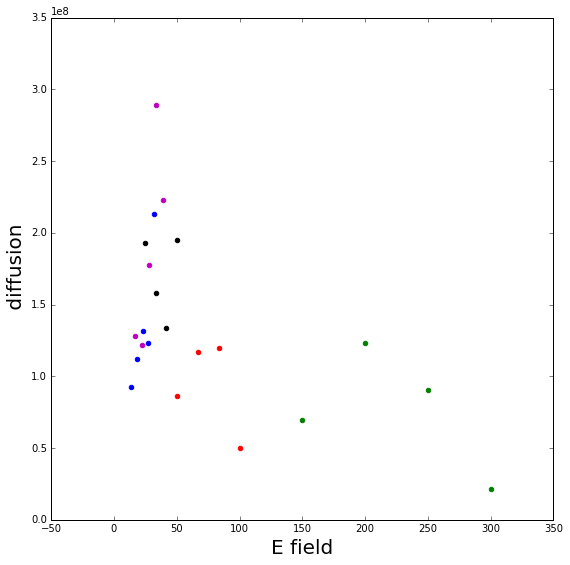

In [262]:
col=['b','g','r','k','m']
plt.figure(figsize=(9,9))
for x in range(0,len(PRE)):
    if PRE[x]==1:
        plt.scatter(REDU[x],Dl[x]/Mu[x]*1e8,color=col[1])
        #plt.errorbar(EFID[x],Dl[x]*1e8,yerr=100,color=col[1])
    if PRE[x]==3:
        plt.scatter(REDU[x],Dl[x]/Mu[x]*1e8,color=col[2])
        #plt.errorbar(EFID[x],Dl[x]*1e8,yerr=100,color=col[2])
    if PRE[x]==6:
        plt.scatter(REDU[x],Dl[x]/Mu[x]*1e8,color=col[3])
        #plt.errorbar(EFID[x],Dl[x]*1e8,yerr=100,color=col[3])
    if PRE[x]==9:
        plt.scatter(REDU[x],Dl[x]/Mu[x]*1e8,color=col[4])
        #plt.errorbar(EFID[x],Dl[x]*1e8,yerr=100,color=col[4])
    if PRE[x]==11:
        plt.scatter(REDU[x],Dl[x]/Mu[x]*1e8,color=col[0])
        #plt.errorbar(EFID[x],Dl[x]*1e8,yerr=100,color=col[0])
        
#plt.scatter(REDU,difff)
plt.xlabel('E field',fontsize=20)
plt.ylabel(' diffusion',fontsize=20)
#plt.scatter(dd[:,0],dd[:,1],color='y')
#plt.xlim(50,370)

In [24]:
dd = np.genfromtxt('/Users/austinmcdonald/Desktop/set.csv',delimiter=',')

In [25]:
dd[:,0]

array([ 22.90880631,  28.49373882,  25.98076923,  26.41413238,
        28.55826151,  28.07867133,  29.96202635,  33.18657505,
        34.04756871,  38.06334363,  38.02333713,  38.29094162,
        42.05216295,  43.44738982,  44.35826964,  47.57196292,
        48.54907302,  53.65051228,  57.1358351 ])

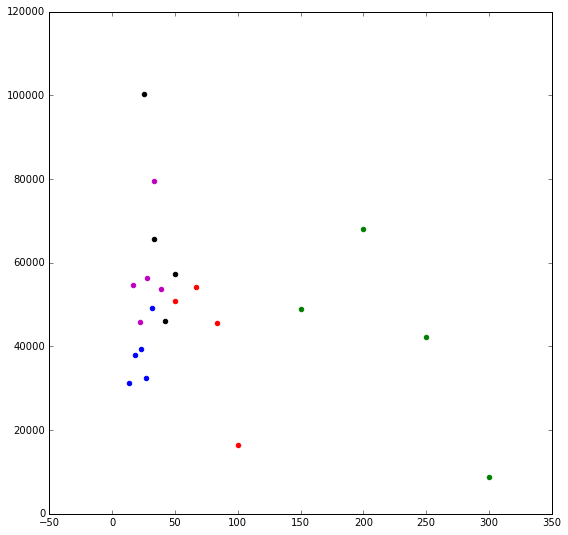

In [266]:
col=['b','g','r','k','m']
plt.figure(figsize=(9,9))
for x in range(0,len(PRE)):
    if PRE[x]==1:
        plt.scatter(REDU[x],Dl[x]*1e8,color=col[1])
    if PRE[x]==3:
        plt.scatter(REDU[x],Dl[x]*1e8,color=col[2])
    if PRE[x]==6:
        plt.scatter(REDU[x],Dl[x]*1e8,color=col[3])
    if PRE[x]==9:
        plt.scatter(REDU[x],Dl[x]*1e8,color=col[4])
    if PRE[x]==11:
        plt.scatter(REDU[x],Dl[x]*1e8,color=col[0])
        
#plt.scatter(REDU,difff)
#plt.scatter(dd[:,0],dd[:,1],color='y')
#plt.xlim(0,75)

//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in true_divide


(0, 0.15)

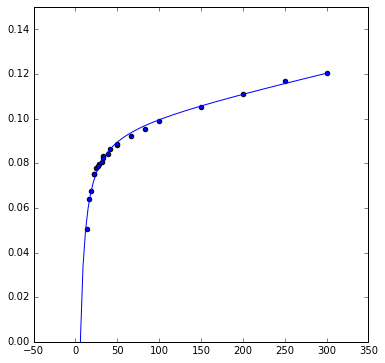

In [251]:
xnew = np.linspace(0,300,100)
def polyy(x,a,b,c):
    #return a*np.sqrt(x)+b+c*x+d
    return -a/x+b +c*x
popt,pcov = optimize.curve_fit(polyy,REDU,Vd)
plt.figure(figsize=(6,6))
plt.plot(xnew,polyy(xnew,*popt))
plt.scatter(REDU,Vd)
plt.ylim(0,0.15)

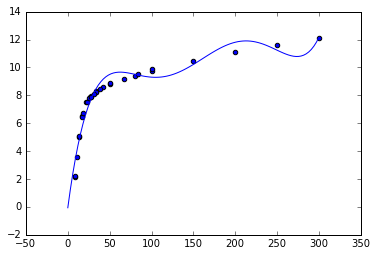

In [84]:
coefs = poly.polyfit(REDU, Vd*100, 5)
xnew = np.linspace(0,300,100)
ffit = poly.polyval(xnew, coefs)

plt.scatter(REDU,Vd*100)
plt.plot(xnew,ffit)

In [ ]:
np.sqrt(273/296*12)*np.sqrt(Dl/Vd)

In [ ]:
np.sqrt(273/296*12)

In [ ]:
####Xe-008_P-01_E-100.txt
#Xe-099_P-0302_E-250.txt
#Xe-099_P-0302_E-040.txt
#Xe-099_P-0901_E-080.txt
#Xe-099_P-0995_E-250.txt
#Xe-099_P-0601_E-250.txt
#Xe-100_P-1080_E-080.txt
#Xe-100_P-0302_E-100.txt
#Xe-100_P-0101_E-100.txt
#Xe-100_P-1080_E-250.txt
#Xe-100_P-0101_E-250.txt
##Xe-100_P-1080_E-300.txt
#Xe-100_P-1080_E-100.txt
#Xe-100_P-0302_E-040.txt
#Xe-100_P-0607_E-300.txt
#Xe-035_P-01_E-080.txt
#Xe-035_P-06_E-200.txt

In [ ]:
Xe-035_P-01_E-080.txt
Xe-035_P-11_E-080.txt
Xe-035_P-06_E-200.txt

In [ ]:
PATH = '/Users/austinmcdonald/Desktop/Xenon/Data/100/'
PP = "Xe-100_P-0909_E-200.txt"
Data = np.loadtxt(PATH+PP)

In [ ]:
plt.figure(figsize=(9,9))
plt.plot(Data[0],Data[1])
X,Y,O = FITTER_GOLD(Data[0],Data[1])
print(O)
plt.plot(X,func(X,*O),color='r')
plt.plot(Data[0],Data[2])
X,Y,O = FITTER_ANOD(Data[0],Data[2])
print(O)
plt.plot(X,func(X,*O),color='r')
#plt.xlim(0,0.001)

In [ ]:
def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

In [ ]:
#plt.plot(Data[0],Data[1])
X,Y,O = FITTER_GOLD(Data[0],Data[1])
O

In [ ]:
# arrival, sigma, max, RC
xval = np.linspace(-.0001,0.002,10000)

X,Y,O = FITTER_GOLD(Data[0],Data[1])
plt.plot(xval,gaus(xval,O[2],O[0],O[1]),color='r')
X,Y,O = FITTER_ANOD(Data[0],Data[2])
plt.plot(xval,gaus(xval,O[2],O[0],O[1]),color='g')
plt.xlim(-1e-5,3e-4)

In [ ]:
X,Y,O = FITTER_GOLD(Data[0],Data[1])
plt.plot(xval,gaus(xval,1,0,O[1]),color='r')
print(O[1])
X,Y,O = FITTER_ANOD(Data[0],Data[2])
plt.plot(xval,abs(gaus(xval,1,0,O[1])),color='g')
print(O[1])
plt.xlim(-1e-5,1e-5)

In [ ]:
(7.0303106598e-06-4.75471431319e-06)*1e6


In [ ]:
(6.13364779471e-06)*1e6*13.8